In [3]:
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datatypes import convert_to
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.annotation.ggs import GreedyGaussianSegmentation
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import os

def load_data(data_dir='../data/raw'):
    """
    Load all CSV files from the specified directory and concatenate them into a single DataFrame.
    """
    csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    columns_to_load = ['date', 'bgl', 'msg_type', 'affects_fob', 'affects_iob', 'dose_units', 'food_g', 'food_glycemic_index']
    
    dataframes = []
    for file in csv_files:
        df = pd.read_csv(os.path.join(data_dir, file), usecols=columns_to_load, parse_dates=['date'])
        df['patient_id'] = file.split('_')[0]  # Extract patient ID from filename
        dataframes.append(df)
    
    combined_df = pd.concat(dataframes, ignore_index=True, axis=0)
    # combined_df['date'] = dataframes[0]
    print(f"Loaded data from {len(csv_files)} files.")
    return combined_df

df = load_data()
df.head()

Loaded data from 2 files.


,date,bgl,msg_type,affects_fob,affects_iob,dose_units,food_g,food_glycemic_index,patient_id
0,2024-07-01 00:02:39-05:00,98.0,NaN,NaN,NaN,NaN,NaN,NaN,500030
1,2024-07-01 00:07:39-05:00,100.0,NaN,NaN,NaN,NaN,NaN,NaN,500030
2,2024-07-01 00:12:39-05:00,98.0,NaN,NaN,NaN,NaN,NaN,NaN,500030
3,2024-07-01 00:17:39-05:00,94.0,NaN,NaN,NaN,NaN,NaN,NaN,500030
4,2024-07-01 00:22:40-05:00,94.0,NaN,NaN,NaN,NaN,NaN,NaN,500030


In [4]:
from sktime.datasets import load_airline
y = load_airline()
y.head()

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

In [5]:
def preprocess_data(df):
    """
    Preprocess the combined DataFrame.
    ---
    1. Fill NaN values with 0
    2. Replace 0 with 'NULL' in the 'msg_type' column
    3. One hot encode the 'msg_type' column
    4. Drop irrelevant columns for the target variable 
    (in this case, only keeps 'ANNOUNCE_MEAL', 'INTERVENTION_SNACK', 'ANNOUNCE_EXERCISE', 'DOSE_INSULIN', 'DOSE_BASAL_INSULIN')
    5. Drop rows with invalid dates
    """
    df = df.fillna(0)
    df['msg_type'] = df['msg_type'].replace(0, 'NULL')

    # Convert 'date' column to datetime with a custom format
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
    
    # Drop rows where the date is null or invalid
    df = df.dropna(subset=['date'])
    
    # Sort by date and handle duplicate timestamps
    df = df.sort_values('date')
    
    # Handle duplicate timestamps by adding a small time increment
    df['date'] = df.groupby('date').cumcount().add(1).astype('timedelta64[ms]') + df['date']
    
    # Set 'date' as the index
    df.set_index('date', inplace=True)

    RELEVANT_MSG_TYPES = ['ANNOUNCE_MEAL', 'INTERVENTION_SNACK', 'ANNOUNCE_EXERCISE', 'DOSE_INSULIN', 'DOSE_BASAL_INSULIN']
    
    encoder = OneHotEncoder(categories='auto', sparse_output=False)
    encoded_data = encoder.fit_transform(df[['msg_type']])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['msg_type']), index=df.index)
    
    df = df.drop(columns=['msg_type'])
    df = pd.concat([df, encoded_df], axis=1)
    
    COLUMNS_TO_DROP = [col for col in df.columns if 'msg_type' in col and not any(msg_type in col for msg_type in RELEVANT_MSG_TYPES)]
    df.drop(columns=COLUMNS_TO_DROP, inplace=True)
    
    return df

df = preprocess_data(df)
df.head()


,bgl,affects_fob,affects_iob,dose_units,food_g,food_glycemic_index,patient_id,msg_type_ANNOUNCE_EXERCISE,msg_type_ANNOUNCE_MEAL,msg_type_INTERVENTION_SNACK
date,,,,,,,,,,
2024-07-01 04:02:32.001000+00:00,115.0,0,0,0.0,0.0,0.0,679372,0.0,0.0,0.0
2024-07-01 04:05:33.001000+00:00,112.0,0,0,0.0,0.0,0.0,679372,0.0,0.0,0.0
2024-07-01 04:08:33.001000+00:00,116.0,0,0,0.0,0.0,0.0,679372,0.0,0.0,0.0
2024-07-01 04:10:34.001000+00:00,121.0,0,0,0.0,0.0,0.0,679372,0.0,0.0,0.0
2024-07-01 04:13:36.001000+00:00,122.0,0,0,0.0,0.0,0.0,679372,0.0,0.0,0.0


In [6]:
test = df.drop(columns=[col for col in df.columns if 'msg_type' in col or 'patient_id' in col])
test.head()


,bgl,affects_fob,affects_iob,dose_units,food_g,food_glycemic_index
date,,,,,,
2024-07-01 04:02:32.001000+00:00,115.0,0,0,0.0,0.0,0.0
2024-07-01 04:05:33.001000+00:00,112.0,0,0,0.0,0.0,0.0
2024-07-01 04:08:33.001000+00:00,116.0,0,0,0.0,0.0,0.0
2024-07-01 04:10:34.001000+00:00,121.0,0,0,0.0,0.0,0.0
2024-07-01 04:13:36.001000+00:00,122.0,0,0,0.0,0.0,0.0


In [9]:
def greedy_gaussian_segmentation(df):
    """
    Perform greedy Gaussian segmentation on the DataFrame using sktime's GreedyGaussianSegmentation.
    """
    # Separate X and y
    # X = df.drop(columns=[col for col in df.columns if 'msg_type' in col or 'patient_id' in col])
    X = df.drop(columns=[col for col in df.columns if col != 'bgl'])

    # Ensure X is not empty
    if X.empty:
        raise ValueError("X is empty after dropping columns. Check your column names and filtering.")

    # Convert X to the required format for sktime
    X_2d = X.values
    X_nested = X

    # X_nested = from_2d_array_to_nested(X_2d, index=X.index)

    # Ensure X_nested is not empty and has the correct shape
    if X_nested.empty or X_nested.shape[1] == 0:
        raise ValueError("X_nested is empty or has no columns. Check the conversion process.")

    # Initialize and fit the segmentation model
    segmenter = GreedyGaussianSegmentation(k_max=10)  # Adjust k_max as needed
    
    # Fit the model
    try:
        segmentation = segmenter.fit_predict(X_nested)
    except Exception as e:
        print(f"Error during fitting: {e}")
        print(f"X_nested shape: {X_nested.shape}")
        print(f"X_nested dtypes: {X_nested.dtypes}")
        raise

    return segmentation, X_nested

# Use the function
# try:
segmentation, X_nested = greedy_gaussian_segmentation(df)
X_nested.head()
# visualize_segmentation(X_nested, segmentation)
# except Exception as e:
#     print(f"An error occurred: {e}")
#     print(f"DataFrame shape: {df.shape}")
#     print(f"DataFrame columns: {df.columns}")
#     print(f"DataFrame dtypes: {df.dtypes}")

,bgl
2024-07-01 04:02:32.001000+00:00,115.0
2024-07-01 04:05:33.001000+00:00,112.0
2024-07-01 04:08:33.001000+00:00,116.0
2024-07-01 04:10:34.001000+00:00,121.0
2024-07-01 04:13:36.001000+00:00,122.0


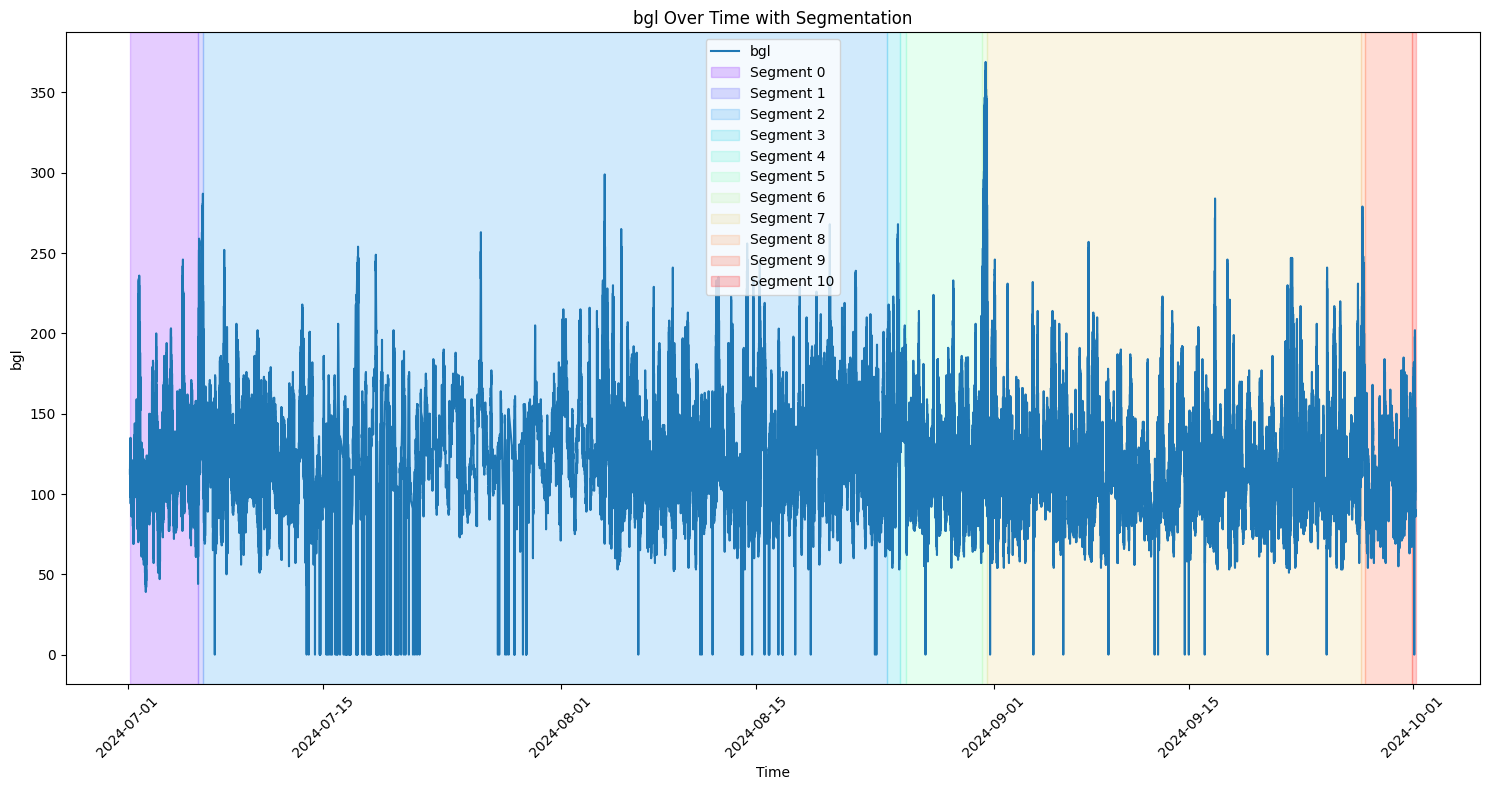

In [13]:
def visualize_segmentation(X_nested, segmentation, column_name='bgl'):
    '''
    Visualize the segmented time series data
    ---
    X_nested: the time series data
    segmentation: of shape (n_samples, ) where n_samples is the number of samples in X_nested
        each entry in segmentation is an integer indicating the segment number
    column_name: the name of the column to plot
    '''
    plt.figure(figsize=(15, 8))
    
    # plot the time series
    plt.plot(X_nested.index, X_nested[column_name].values.flatten(), label=column_name)
    
    # plot segmentation
    unique_segments = np.unique(segmentation)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))
    
    for segment, color in zip(unique_segments, colors):
        mask = segmentation == segment
        plt.axvspan(X_nested.index[mask].min(), X_nested.index[mask].max(), 
                    alpha=0.2, color=color, label=f'Segment {segment}')
    
    plt.title(f'{column_name} Over Time with Segmentation')
    plt.xlabel('Time')
    plt.ylabel(column_name)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# segmentation.shape
visualize_segmentation(X_nested, segmentation)